### testing sentinel-1 to detect flooded forests

- [ ] bring in coastal tile (or smaller area)
- [ ] get tide for area using fes2104 from dea_coastal tools
- [ ] load in sentinel-1 for high and low tide examples, filter etc and plot up


In [1]:
import sys

import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table

import odc.stac
from datacube.utils.cog import write_cog

from scipy.ndimage import uniform_filter
from scipy.ndimage import variance

from IPython.display import Image

### Tide modelling tools
sys.path.insert(1, "/home/jovyan/code/dea-notebooks/Tools") # needed pip3 install OWSLib
from dea_tools.coastal import model_tides,tidal_tag, pixel_tides, tidal_stats



# GRD perhaps?
# VV seems a winner
# plotting up FES2014 model outside of DEA requires a bit of setup - maybe do within for now either two notebooks or bring this into dea


In [2]:
# MPC catalog connect
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Defining a file path
vector_file = '../data/geojson/map.geojson'
# Define time period of interest
time = "2020-02-07/2020-02-28"


gdf = gpd.read_file(vector_file)

# Visualizing 
gdf.explore()

In [7]:
gdf_polygon = gdf[gdf.geometry.geom_type == 'Polygon']
gdf_point = gdf[gdf.geometry.geom_type == 'Point']

polygon_bbox = [gdf_polygon.geometry.bounds.minx.min(), gdf_polygon.geometry.bounds.miny.min(), gdf_polygon.geometry.bounds.maxx.max(), gdf_polygon.geometry.bounds.maxy.max()]
point_bbox = [gdf_point.geometry.bounds.minx.min(), gdf_point.geometry.bounds.miny.min(), gdf_point.geometry.bounds.maxx.max(), gdf_point.geometry.bounds.maxy.max()]

# search MPC collections
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=polygon_bbox, datetime=time)
items = search.item_collection()
print(f"Found {len(items)} items")
item = items[0]

Found 5 items


In [8]:
%%time
# load as odc stac dataset
ds_s1 = odc.stac.load(items,
                        bbox=polygon_bbox,
                        crs="EPSG:3577",
                        resolution=10,
                        groupby='solar_day')

CPU times: user 1.91 s, sys: 1.11 s, total: 3.01 s
Wall time: 3.57 s


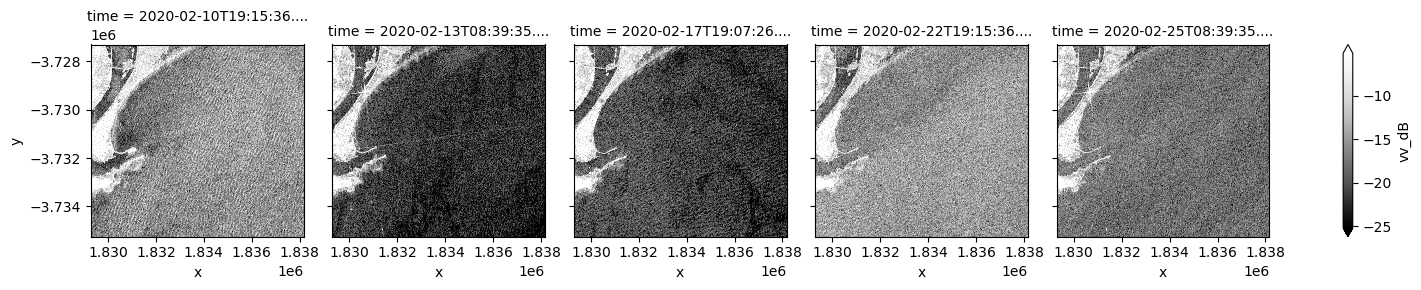

In [9]:
# Scale to plot data in decibels
ds_s1["vv_dB"] = 10 * np.log10(ds_s1.vv)

# Plot all VV observations for the year
ds_s1.vv_dB.plot(cmap="Greys_r", robust=True, col="time", col_wrap=5)
plt.show()

In [11]:
%%time
# load as odc stac dataset
ds_s1 = odc.stac.load(items,
                        bbox=polygon_bbox,
                        crs="EPSG:3577",
                        resolution=10,
                        groupby='solar_day')

out_stats = tidal_stats(ds_s1)


Setting tide modelling location from dataset centroid: 151.83, -32.91


FileNotFoundError: Invalid tide directory